
# Paddy Disease Classification — **PyTorch + timm**

This is a **minimal, beginner-friendly** image classification pipeline using **PyTorch** and **[timm](https://github.com/huggingface/pytorch-image-models)** (Torch Image Models).  
Typical steps:

1) Setup & configuration  
2) Dataset & transforms (train/valid split)  
3) Model (transfer learning with `timm.create_model`)  
4) Training loop (loss/optimizer)  
5) Evaluation & confusion matrix  
6) (Optional) Inference on test set + `submission.csv`

> **Note:** Point `DATA_DIR` to your local Kaggle Paddy dataset. 


## 1) Setup & Configuration

In [20]:

# If timm isn't installed, uncomment:
# !pip install timm --quiet

import os, random, math, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

from torchvision import datasets, transforms
import timm

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

DATA_DIR = Path("./data/")  
DATA_DIR_TRAIN = Path("./data/train_images/")
 
TRAIN_CSV = DATA_DIR / 'train.csv'
TRAIN_IMG_ROOT = DATA_DIR   / 'train_images'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

import matplotlib.pyplot as plt

#this makes sure that colab instances running this notebook can get to included utils_kp.py
try:
    import utils_kp as ut
except ModuleNotFoundError:
    !wget https://raw.githubusercontent.com/CNUClasses/471_code/master/week6/utils_kp.py
import utils_kp as ut
 
BATCH_SIZE = 256

# lr=0.01 #start with this one (its too high see lr finder below)
lr=2e-3 #lr finder approved this one

NUM_EPOCHS=10

Device: cuda


## 1) Get Data

Data comes from <strong><a href="https://www.kaggle.com/competitions/paddy-disease-classification">Paddy Doctor: Paddy Disease Classification</a></strong>.  A Kaggle competition whose goal is to identify the type of disease present in rice paddy leaf images. You can download it directly after signing up for a <a href="https://www.kaggle.com/">Kaggle</a> account.<br>

### (Optional)
A better way to get the data is through the <strong><a href="https://www.kaggle.com/docs/api">Kaggle CLI (command line interface)</a></strong>.<br>
It lets you programatically interact with Kaggle (get/browse datasets and competitions and submit results)<br>
BTW- you need to have an API key in order to use the CLI, to get one:<br>
Scroll to the API section in your Account settings and click the Create New API Token button.<br>
Kaggle will generate a JSON file named kaggle.json and prompt you to save the file to your computer.<br>
Put this file in the ~/.kaggle directory on your machine, make sure its only readable by you (chmod 600 /root/.kaggle/kaggle.json)<br>
The CLI looks in this place for your key.<br>



In [21]:
# !pip install --upgrade kaggle  #upgrade or install kaggle CLI
# !mkdir -p ~/.kaggle  #create a place for kaggle.json file
# get the key from above, download it and place it in ~/.kaggle/kaggle.json

# the \" below ensures the " marks are written to the file
# {"username":"kperkins411","key":"99914baaed4f708632c750296a5fee1e"}
# !echo "{\"username\":\"youruserid\",\"key\":\"yourkey\"}" > ~/.kaggle/kaggle.json


In [22]:
# !kaggle datasets list #active competitions
# !kaggle datasets list -s paddy-disease-classification  #the one we want
# !kaggle competitions download -c paddy-disease-classification #get it
# !unzip paddy-disease-classification.zip -d ./data/  #unzip it


## 2) Create datasets with timm transforms 

If your data follows the Kaggle layout (`train_images/` and `train.csv` with `image_id,label`), use this dataset class.  



In [23]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

# MODEL_NAME = "resnet18"  # try: 'efficientnet_b0', 'convnext_tiny', 'mobilenetv3_large_100', ...
MODEL_NAME = 'convnext_tiny'
config = timm.data.resolve_data_config({}, model=MODEL_NAME)
train_tfms = timm.data.create_transform(**config, is_training=True, hflip=0.5, auto_augment=None)
valid_tfms = timm.data.create_transform(**config, is_training=False)

pp.pprint(config)

{   'crop_mode': 'center',
    'crop_pct': 0.875,
    'input_size': (3, 224, 224),
    'interpolation': 'bicubic',
    'mean': (0.485, 0.456, 0.406),
    'std': (0.229, 0.224, 0.225)}


In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

full_ds = datasets.ImageFolder(DATA_DIR_TRAIN, transform=train_tfms)
n_total = len(full_ds)
print(f"Total images: {n_total}")
n_valid = int(0.1 * n_total)
n_train = n_total - n_valid
targets = np.array(full_ds.targets)
sss = StratifiedShuffleSplit(n_splits=1, test_size=n_valid, random_state=42)
train_idx, valid_idx = next(sss.split(np.arange(n_total), targets))

train_ds = torch.utils.data.Subset(full_ds, train_idx)
valid_ds = torch.utils.data.Subset(full_ds, valid_idx)
#should be stratified split, but close enough for now
# train_ds, valid_ds = random_split(full_ds, [n_train, n_valid], generator=torch.Generator().manual_seed(42))
print(f"Train images: {len(train_ds)}")
print(f"Valid images: {len(valid_ds)}")


Total images: 10407
Train images: 9367
Valid images: 1040


### or just subclass PaddyMultitaskDataset

In [25]:
class PaddyDataset(ut.PaddyMultitaskDataset):
    def __init__(self, df, img_root, transform=None):
        super().__init__(df, img_root, transform)

    def __len__(self):
        return super().__len__()
    
    def __getitem__(self, idx):
        img, y_var, y_age, y_label = super().__getitem__(idx)
        return img, y_label

train_df, valid_df, test_df=ut.getdataframes(DATA_DIR, TRAIN_CSV, TRAIN_IMG_ROOT, valid_pct=0.1, test_pct=0.1,verbose=True )

train_ds = PaddyDataset(train_df, TRAIN_IMG_ROOT, transform=train_tfms)
valid_ds = PaddyDataset(valid_df,   TRAIN_IMG_ROOT, transform=valid_tfms)
test_ds  = PaddyDataset(test_df,  TRAIN_IMG_ROOT, transform=valid_tfms) 

print('Label classes:', train_ds.labels)
print('Variety classes:', train_ds.varieties)
print('Train/Valid/test sizes:', len(train_ds), len(valid_ds), len(test_ds))


Label classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']
Variety classes: ['ADT45', 'AndraPonni', 'AtchayaPonni', 'IR20', 'KarnatakaPonni', 'Onthanel', 'Ponni', 'RR', 'Surya', 'Zonal']
Train/Valid/test sizes: 8327 1040 1040


## 3) Create Dataloaders

- Shuffle the training loader; keep validation loader deterministic.  
- Adjust `BATCH_SIZE` to fit your GPU/CPU memory.

This is a datascience competition:<br>
the train_images folder contains images with class membership info (in the train.csv file).<br>
the test_images folder contains images that your model infers membership on.  These inferences are bundled into a file (see sample_submission.csv) which is submitted for ranking  

In [26]:

train_images = DATA_DIR / "train_images"
train_csv    = DATA_DIR / "train.csv"
class_names = list(full_ds.class_to_idx.keys())
num_classes = len(class_names)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)

# print(f"Classes ({num_classes}):", class_names[:10], "..." if num_classes>10 else "")
print("Train/Valid/Test sizes:", len(train_ds), len(valid_ds), len(test_ds))


Train/Valid/Test sizes: 8327 1040 1040


### Look at a few of the images

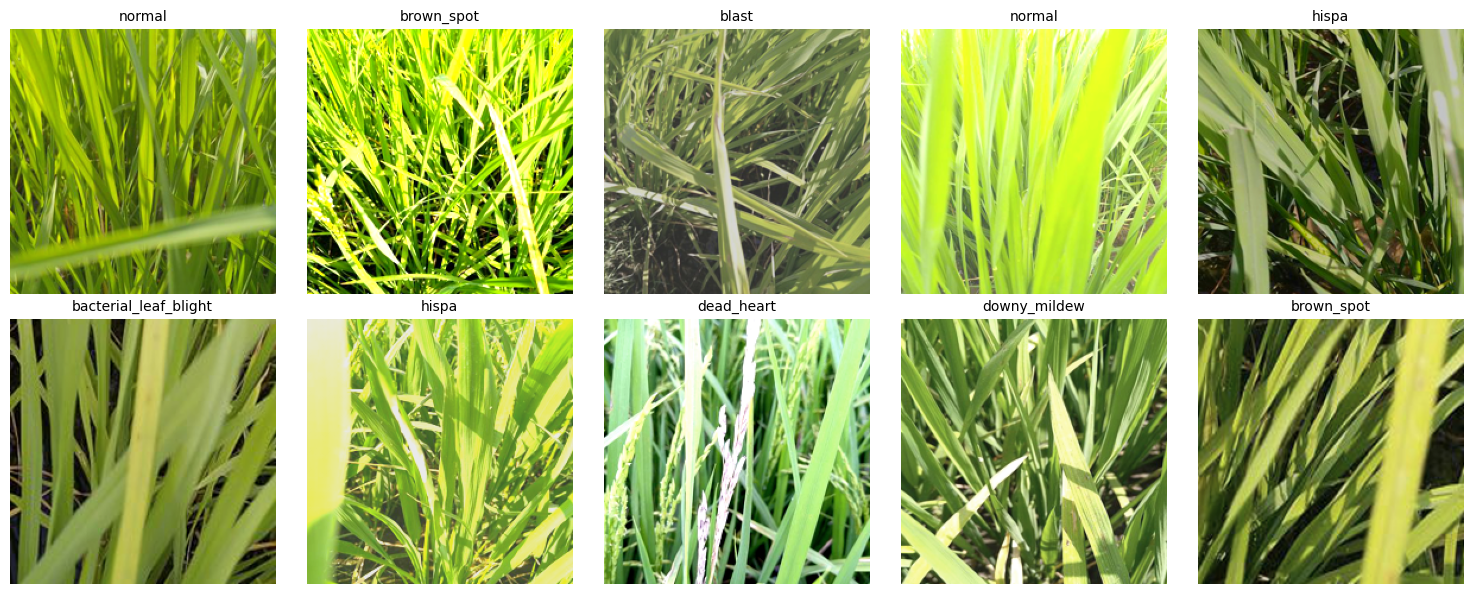

In [27]:
# Display first 10 images + class names from train_loader
# Uses existing variables: train_loader, class_names, config, plt, np, torch

batch = next(iter(train_loader))
xb, yb = batch
num = min(10, xb.size(0))

imgs = xb[:num].clone()  # shape: (num, 3, H, W)
labels_idx = yb[:num].tolist()
labels = [class_names[i] for i in labels_idx]

# un-normalize using config mean/std (expects (3,) tuples)
mean = torch.tensor(config['mean']).view(3, 1, 1)
std = torch.tensor(config['std']).view(3, 1, 1)

# imgs are on CPU (from dataloader); if not, move mean/std to same device
mean = mean.to(imgs.device)
std = std.to(imgs.device)

# create subplots (2 rows x 5 cols)
cols = 5
rows = int(np.ceil(num / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

for i in range(rows * cols):
    ax = axes[i]
    if i < num:
        img = imgs[i] * std + mean  # unnormalize
        npimg = img.numpy().transpose(1, 2, 0)
        npimg = np.clip(npimg, 0, 1)
        ax.imshow(npimg)
        ax.set_title(labels[i], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 4) Load timm Model (Transfer Learning with **timm**)

- Create a **pretrained** model with `num_classes` = 10 (PaddyDoctor classes).  
- **Warm-up:** freeze backbone; train the classifier head first.



In [28]:
def make_model(model_name, num_classes, device, verbose=False):
    """Create and prepare a timm model for transfer learning.

    This function:
    - expects a timm model name and number of output classes
    - will create a pretrained model (weights from ImageNet)
    - freezes all parameters so the backbone is not trained initially
    - later code will unfreeze the classifier/head only so you can warm-up the head

    Args:
        model_name (str): name of timm model (e.g. 'convnext_tiny')
        num_classes (int): number of output classes for the classifier head
        device (torch.device): device to move the model to
        verbose (bool): print classifier info when True

    Returns:
        torch.nn.Module: the created model

    Example Usage:
        model = make_model('convnext_tiny', 10, device)
    """
    #pre trained =True or you get random weights
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    if verbose: print("Classifier layer:", model.get_classifier())

    # Freeze backbone; train classifier head first
    for name, p in model.named_parameters():
        p.requires_grad = False

    # Unfreeze classifier / head only (name depends on model family; get via get_classifier())
    clf_name = model.get_classifier()

    #make sure the last classifier layer is trainable
    for name, p in clf_name.named_parameters():
        p.requires_grad = True

    model = model.to(device)
    return model

In [29]:

model=make_model(MODEL_NAME, num_classes, device)

In [30]:
#check to see the model structure
# print(model.backbone)

#stopped here 9/29/25
# print(model)

In [31]:
#make sure just training the last layer
# for name, p in model.named_parameters():
#     print (f'Name={name},p.shape={p.shape}, p.requires_grad = {p.requires_grad}')



## 5) Optimizer & loss 


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

### (Optional) Use the learning rate finder to help set initial Learning Rate

For a sweep of learning rates, reinitialize the model for each rate, train for a **few batches**, and save (learning rate, loss). <br>
When done plot the loss versus learning rate, then choose the largest learning rate on the descending slope—just before the loss starts rising.

In [33]:


# For a sweep of learning rates, reinitialize the model for each rate, train for a **few batches**, and save (learning rate, loss). <br>
# When done plot the loss versus learning rate, then choose the largest learning rate on the descending slope—just before the loss starts rising.
class LearningRateFinder:
    """
    Utility class to help find an optimal learning rate for training neural networks.
    This class runs a series of short training loops over a range of learning rates,
    records the average loss for each, and provides a method to plot the results.
    The goal is to help select a learning rate that leads to rapid loss decrease
    without instability.
    Args:
        model_fn (callable): A function that returns a new instance of the model to be trained.
        criterion (callable): The loss function to use for training.
        device (torch.device or str): The device on which to run the model and data.
    Attributes:
        model_fn (callable): Function to instantiate the model.
        criterion (callable): Loss function.
        device (torch.device or str): Device for computation.
        results (list): Stores tuples of (learning rate, average loss).
    Methods:
        run(lr_list, train_loader, num_batches=5):
            Runs training for each learning rate in lr_list for a few batches,
            records the average loss, and stores the results.
        plot():
            Plots the recorded average losses against the learning rates on a log scale.
    
    Example usage:
        lr_candidates = np.logspace(-6, -1, num=8)
        finder = LearningRateFinder(make_model, criterion, device)
        results = finder.run(lr_candidates, train_loader, num_batches=5)
        finder.plot()

        best_lr, best_loss = min(results, key=lambda t: t[1])
        best_lr, best_loss
    
    """

    def __init__(self, model_name, num_classes, criterion, device):
        self.model_name = model_name
        self.num_classes = num_classes  
        self.criterion = criterion
        self.device = device
        self.results = []

    def _reinit(self):
        return make_model(self.model_name, self.num_classes, self.device)

    def run(self, lr_list, train_loader, num_batches=5):
        self.results.clear()
        for lr in lr_list:
            model = self._reinit()
            optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
#            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            model.train()
            it = iter(train_loader); losses = []
            for _ in range(num_batches):
                xb, yb = next(it)
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad(set_to_none=True)
                logits = model(xb)
                loss = self.criterion(logits, yb)
                loss.backward(); optimizer.step()
                losses.append(loss.item())
            avg_loss = float(np.mean(losses)) if losses else float('nan')
            self.results.append((float(lr), avg_loss))
        return self.results

    def plot(self):
        if not self.results:
            print("No results. Run .run() first."); return
        lrs, losses = zip(*self.results)
        plt.figure()
        plt.plot(lrs, losses, marker='o')
        plt.xscale('log')
        plt.xlabel("Learning Rate"); plt.ylabel("Average Loss (few batches)")
        plt.title("LR Finder — Loss vs Learning Rate"); plt.show()


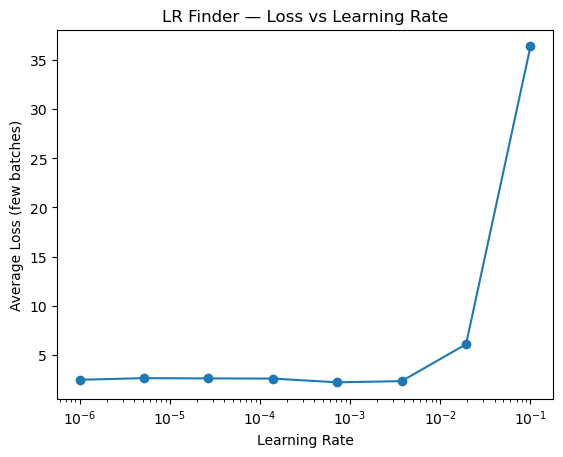

(0.0007196856730011522, 2.2249892234802244)

In [34]:

lr_candidates = np.logspace(-6, -1, num=8)
finder = LearningRateFinder(MODEL_NAME, num_classes, criterion, device)
results = finder.run(lr_candidates, train_loader, num_batches=5)
finder.plot()

best_lr, best_loss = min(results, key=lambda t: t[1])
best_lr, best_loss


# 6) Training & validation loop

- Log train/valid **loss** and **accuracy** per epoch.  

In [35]:
%%time 

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb) #loss is the avearege over the batch (so multiply by batch size below)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)  #loss is the avearege over the batch (so multiply by batch size below)
        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return total_loss/total, correct/total

def train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, num_epochs=10):
    for epoch in range(1, num_epochs + 1):
        # Train for one epoch
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)

        # Evaluate on validation set
        va_loss, va_acc = evaluate(model, valid_loader, criterion)
        print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | valid loss {va_loss:.4f} acc {va_acc:.3f}")

train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)


Epoch 01 | train loss 1.5829 acc 0.464 | valid loss 1.0584 acc 0.627
Epoch 02 | train loss 1.1728 acc 0.599 | valid loss 0.8623 acc 0.716
Epoch 03 | train loss 1.0538 acc 0.644 | valid loss 0.8138 acc 0.722
Epoch 04 | train loss 1.0096 acc 0.652 | valid loss 0.7571 acc 0.752
Epoch 05 | train loss 0.9635 acc 0.680 | valid loss 0.7398 acc 0.755
Epoch 06 | train loss 0.9295 acc 0.686 | valid loss 0.6657 acc 0.784
Epoch 07 | train loss 0.9249 acc 0.689 | valid loss 0.6444 acc 0.781
Epoch 08 | train loss 0.8847 acc 0.700 | valid loss 0.6359 acc 0.782
Epoch 09 | train loss 0.8683 acc 0.706 | valid loss 0.6462 acc 0.795
Epoch 10 | train loss 0.8611 acc 0.710 | valid loss 0.6001 acc 0.803
CPU times: user 1min 19s, sys: 15.8 s, total: 1min 35s
Wall time: 7min 6s


### (Optional) Fine-tune the whole network

After warming up the head, unfreeze the backbone and fine-tune at a **smaller LR**.

In [ ]:
%%time 

# train the whole thing (unfreeze all layers)
for p in model.parameters():
    p.requires_grad = True

#make lr smaller for fine-tuning
lr1=lr/10

#reinitialize optimizer so we can train all parameters
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr1)
train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)


Epoch 01 | train loss 2.8888 acc 0.178 | valid loss 2.1516 acc 0.163
Epoch 02 | train loss 2.1609 acc 0.179 | valid loss 2.1593 acc 0.173
Epoch 03 | train loss 2.1535 acc 0.179 | valid loss 2.1198 acc 0.220
Epoch 04 | train loss 2.1272 acc 0.209 | valid loss 2.0521 acc 0.261
Epoch 05 | train loss 2.0058 acc 0.281 | valid loss 1.7804 acc 0.384
Epoch 06 | train loss 1.6761 acc 0.418 | valid loss 1.3190 acc 0.579
Epoch 07 | train loss 1.1707 acc 0.599 | valid loss 0.7506 acc 0.755
Epoch 08 | train loss 0.8291 acc 0.719 | valid loss 0.4677 acc 0.846
Epoch 09 | train loss 0.6336 acc 0.789 | valid loss 0.3162 acc 0.891
Epoch 10 | train loss 0.4967 acc 0.833 | valid loss 0.2890 acc 0.911
CPU times: user 4min 17s, sys: 15.9 s, total: 4min 33s
Wall time: 7min 17s


## 7) Save / Load model

In [37]:

torch.save(model.state_dict(), 'kaggle_paddy_timm_multihead.pth')
print('Saved to kaggle_paddy_timm_multihead.pth')
model.load_state_dict(torch.load('kaggle_paddy_timm_multihead.pth', map_location=device))



Saved to kaggle_paddy_timm_multihead.pth


/tmp/ipykernel_2737918/3246647191.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('kaggle_paddy_timm_multihead.pth', map_location=device

<All keys matched successfully>

## 8) Evaluation & Confusion Matrix

Evaluate the model on the test_loader.  This is the **only** time the model sees this loader

In [38]:
LOADER=test_loader

@torch.no_grad()
def get_all_preds_targets(model, loader):
    model.eval()
    preds, targs = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
        targs.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targs)

preds, targs = get_all_preds_targets(model, LOADER)

# Confusion matrix
num_classes = len(class_names)
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(targs, preds):
    cm[t, p] += 1

print('Confusion Matrix (6x6 for PaddyDoctor):')
print(cm)

# Per-class metrics
per_class = []
for k in range(num_classes):
    TP = cm[k,k]
    FP = cm[:,k].sum() - TP
    FN = cm[k,:].sum() - TP
    TN = cm.sum() - TP - FP - FN
    prec = TP/(TP+FP) if (TP+FP)>0 else 0.0
    rec  = TP/(TP+FN) if (TP+FN)>0 else 0.0
    f1   = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0
    per_class.append((prec, rec, f1))

macro_p = float(np.mean([p for p,_,_ in per_class]))
macro_r = float(np.mean([r for _,r,_ in per_class]))
macro_f = float(np.mean([f for _,_,f in per_class]))
overall_acc = float((preds == targs).mean())

print('\nPer-class (precision, recall, f1):')
for name,(p,r,f) in zip(class_names, per_class):
    print(f'{name:>10s}: P={p:.3f} R={r:.3f} F1={f:.3f}')
print(f"\nMacro avg: P={macro_p:.3f} R={macro_r:.3f} F1={macro_f:.3f}")
print(f'Overall Accuracy: {overall_acc:.3f}')


Confusion Matrix (6x6 for PaddyDoctor):
[[ 50   0   0   5   0   0   2   0   0   0]
 [  0  42   0   1   0   0   1   0   0   0]
 [  0   0  39   0   0   0   0   0   0   0]
 [  0   0   0 161   0   0   2   1   0   0]
 [  1   5   0   5  82   0   4   0   1   1]
 [  0   0   1   0   0 142   0   0   0   0]
 [  0   0   0   3   0   0  58   0   1   5]
 [  0   0   0   5   1   0   5 129   2   3]
 [  0   0   3   1   1   0   0   4 165   0]
 [  0   0   0   6   0   0   2   2   0  98]]

Per-class (precision, recall, f1):
bacterial_leaf_blight: P=0.980 R=0.877 F1=0.926
bacterial_leaf_streak: P=0.894 R=0.955 F1=0.923
bacterial_panicle_blight: P=0.907 R=1.000 F1=0.951
     blast: P=0.861 R=0.982 F1=0.917
brown_spot: P=0.976 R=0.828 F1=0.896
dead_heart: P=1.000 R=0.993 F1=0.996
downy_mildew: P=0.784 R=0.866 F1=0.823
     hispa: P=0.949 R=0.890 F1=0.918
    normal: P=0.976 R=0.948 F1=0.962
    tungro: P=0.916 R=0.907 F1=0.912

Macro avg: P=0.924 R=0.925 F1=0.922
Overall Accuracy: 0.929
